<a href="https://colab.research.google.com/github/elemnurguner/data-ai-projects/blob/main/M%C3%BC%C5%9Fteri_Churn_Tahmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Adım 1: Colab Ortamını Hazırlama


In [ ]:
!pip install imbalanced-learn xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, RocCurveDisplay

📊 Adım 2: Veri Setini Yükleme

In [6]:
# IBM Telco Churn veri seti (Gerçek dünya verisi)
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# Veriyi kontrol edelim
print("Örnek Veri:")
display(df.head())
print("\nEksik Değerler:")
print(df.isnull().sum())

Örnek Veri:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Eksik Değerler:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


🔍 Adım 3: Veri Keşfi ve Ön İşleme


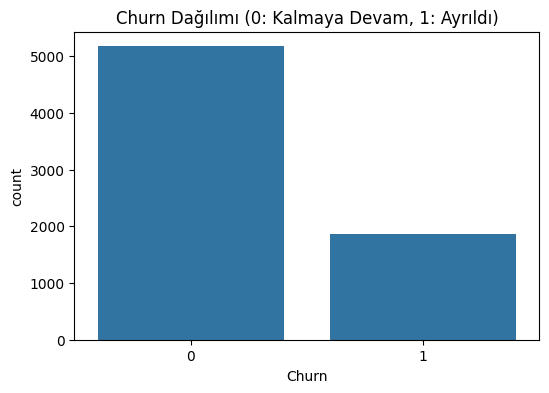

In [7]:
# Gereksiz sütunları çıkar
df = df.drop('customerID', axis=1)

# TotalCharges'taki boşlukları 0 ile doldur
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# Hedef değişkeni kodlama
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

# Kategorik ve sayısal sütunları ayır
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Sınıf dengesizliğini görselleştir
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Dağılımı (0: Kalmaya Devam, 1: Ayrıldı)')
plt.show()

⚙️ Adım 4: Veri Hazırlama Pipeline'ı


In [8]:
# Ön işleme adımları
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# SMOTE ile pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42))
])

# Veriyi bölme
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE'u sadece eğitim verisine uygula
X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

🤖 Adım 5: Model Eğitimi ve Değerlendirme


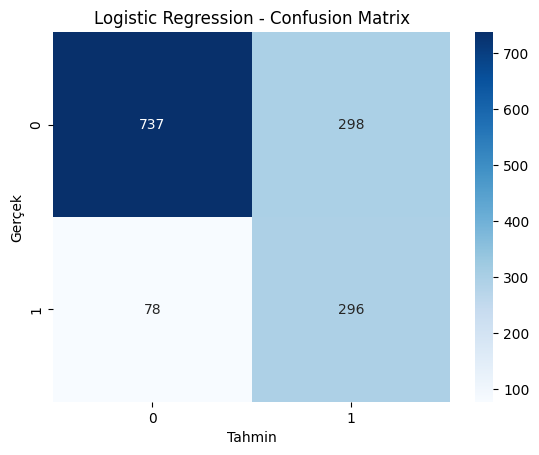

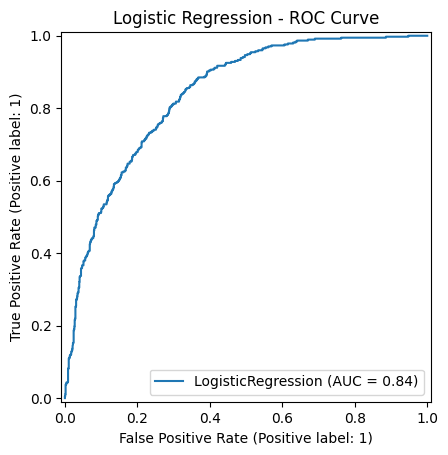

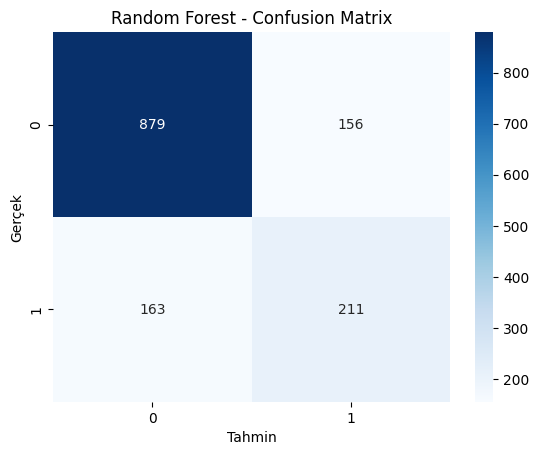

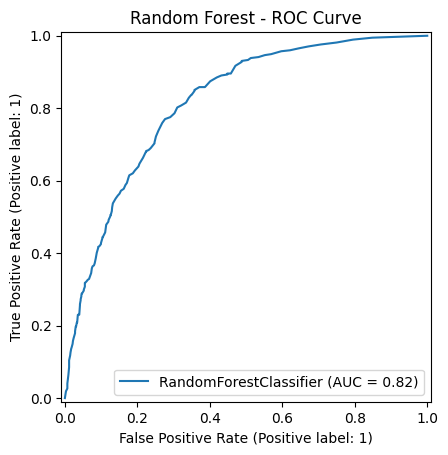

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:19:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


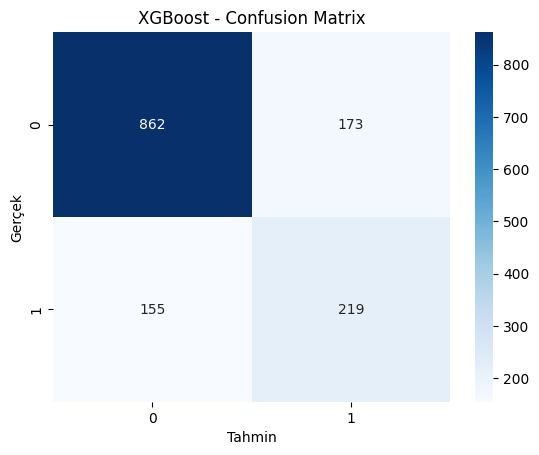

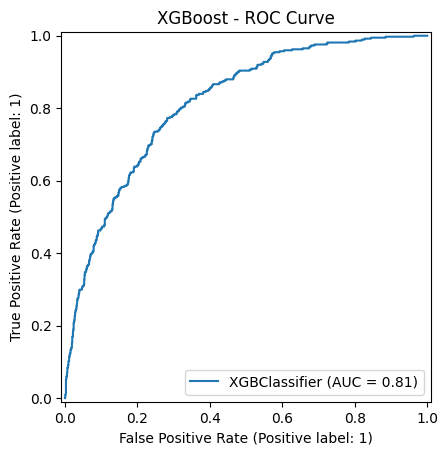


🔎 Model Karşılaştırması:


,Model,F1-Score,ROC AUC
0,Logistic Regression,0.612,0.839
2,XGBoost,0.572,0.815
1,Random Forest,0.570,0.815


In [9]:
# Modeller
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Test verisini hazırla (SMOTE UYGULANMAZ!)
X_test_processed = preprocessor.transform(X_test)

# Sonuçları sakla
results = []

for name, model in models.items():
    # Eğitim
    model.fit(X_train_res, y_train_res)

    # Tahminler
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:,1]

    # Metrikler
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    # Görselleştirme
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Tahmin')
    plt.ylabel('Gerçek')
    plt.show()

    RocCurveDisplay.from_estimator(model, X_test_processed, y_test)
    plt.title(f'{name} - ROC Curve')
    plt.show()

    results.append({
        'Model': name,
        'F1-Score': round(f1, 3),
        'ROC AUC': round(roc_auc, 3)
    })

# Sonuçları göster
results_df = pd.DataFrame(results)
print("\n🔎 Model Karşılaştırması:")
display(results_df.sort_values('F1-Score', ascending=False))